## KL estimate

- http://joschu.net/blog/kl-approx.html
- https://huggingface.co/docs/trl/main/en/grpo_trainer#estimating-the-kl-divergence

$$
\begin{split}
&KL(q\|p)=KL(q,p)=\sum_x q(x)\log\frac{q(x)}{p(x)}=\mathbb E_{x\sim q}\log \frac{q(x)}{p(x)}\\
&KL(p\|q)=KL(p,q)=\sum_x p(x)\log\frac{p(x)}{q(x)}=\mathbb E_{x\sim p}\log \frac{p(x)}{q(x)}
\end{split}
$$

- KL 整体是一个期望（expection）；
    - The most common strategy for estimating sums or integrals is to use a Monte-Carlo estimate.
- a good estimator
    - unbiases (right mean)，刻画偏离；
    - low variance，刻画波动；

### estimator 1: $-\log\frac{p(x)}{q(x)}$

- one unbiased estimator (under samples from $q$) is $\log\frac{q(x)}{p(x)}=-\log \frac{p(x)}{q(x)}$
    - high variance
    - it’s negative for half of the samples, whereas KL is always positive. 
    - “重尾”或大范围波动
- $r=\log \frac{p(x)}{q(x)}$

$$
\begin{split}
k_1=\log \frac{q(x)}{p(x)}&=-\log\frac{p(x)}{q(x)}=-\log r\\
&=\log q(x)-\log p(x)\\
&=\log q - \log p
\end{split}
$$

In [1]:
import torch
import torch.distributions as dist
import matplotlib.pyplot as plt
import numpy as np

In [2]:
p = dist.Normal(loc=0, scale=1)
q = dist.Normal(loc=1, scale=1)
x = q.sample(sample_shape=(10_000_000,))

In [3]:
true_kl = dist.kl_divergence(p, q)
true_kl

tensor(0.5000)

In [4]:
log_q = q.log_prob(x)
log_p = p.log_prob(x)
logr = log_p - log_q

In [5]:
k1 = -logr

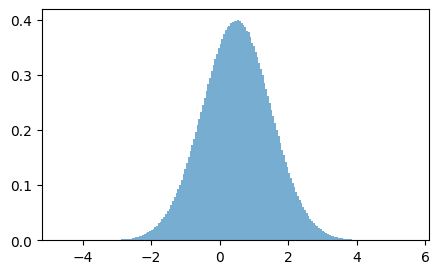

In [6]:
plt.figure(figsize=(5, 3))
_ = plt.hist(k1.numpy(), bins=200, density=True, alpha=0.6, label="Empirical Distribution")

In [7]:
k1.mean(), k1.std()

(tensor(0.4995), tensor(0.9998))

### estimator 2: $\frac12(\log \frac{p(x)}{q(x)})^2=\frac12(\log r)^2$

- lower variance but is biased
    - it’s always positive
    - remarkably low bias. 

In [8]:
k2 = (logr ** 2) / 2

In [9]:
k2.mean(), k2.std()

(tensor(0.6245), tensor(0.8657))

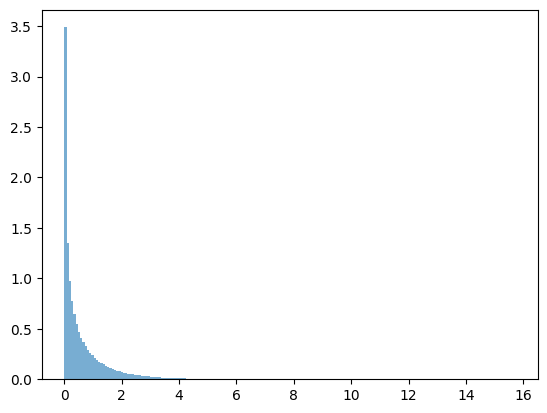

In [10]:
_ = plt.hist(k2.numpy(), bins=200, density=True, alpha=0.6, label="Empirical Distribution")

### estimator 3: $(r-1)-\log r$

- for samples $x \sim q, r=\frac{p(x)}{q(x)}$
$$
\begin{split}
&KL(q,p)=(r-1)-\log r\\
\end{split}
$$

- RL

$$
\mathbb D_{KL}[\pi_\theta\|\pi_{ref}]=\frac{\pi_{ref}(\cdot)}{\pi_\theta(\cdot)}-\log \frac{\pi_{ref}(\cdot)}{\pi_\theta(\cdot)} - 1
$$

In [11]:
k3 = (logr.exp() - 1) - logr

In [12]:
k3.mean(), k3.std()

(tensor(0.4997), tensor(0.8477))

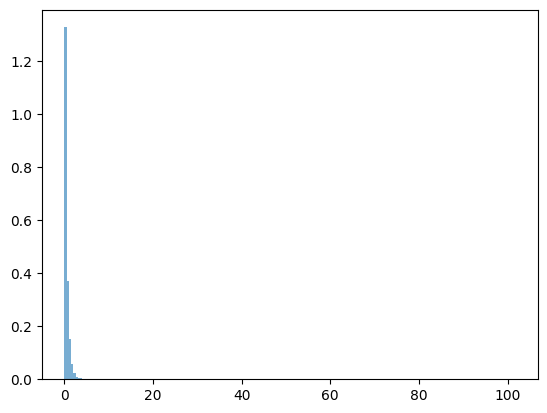

In [13]:
_ = plt.hist(k3.numpy(), bins=200, density=True, alpha=0.6, label="Empirical Distribution")

In [19]:
(k2.mean() - true_kl) / true_kl, k2.std() / true_kl

(tensor(0.2490), tensor(1.7315))

In [18]:
(k3.mean() - true_kl) / true_kl, k3.std() / true_kl

(tensor(-0.0006), tensor(1.6953))

In [17]:
# import torch.distributions as dis
# p = dis.Normal(loc=0, scale=1)
# q = dis.Normal(loc=0.1, scale=1)
# x = q.sample(sample_shape=(10_000_000,))
# truekl = dis.kl_divergence(q, p)
# print("true", truekl)
# logr = p.log_prob(x) - q.log_prob(x)
# k1 = -logr
# k2 = logr ** 2 / 2
# k3 = (logr.exp() - 1) - logr
# for k in (k1, k2, k3):
#     print((k.mean() - truekl) / truekl, k.std() / truekl)